## Business Goal 

Analyse the customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.metrics import precision_score,f1_score,accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale


from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

### Data Sourcing

Load and read telecom_churn_data.csv to a data frame

In [2]:
#Reading data from csv file
data=pd.read_csv(r"C:\Users\Preeti\Downloads\telecom_churn_data.csv")
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [4]:
data.shape

(99999, 226)

### Data Cleaning

In [5]:
#Handle rows with null values more than 70%

null_percent = 0.7
na_percent_rows = round(data.isnull().sum(axis=1) / len(data.columns),2 )
print(f"\nBefore dropping : Number of rows which has more than {round(null_percent*100)}% NULL values = ", 
      na_percent_rows[na_percent_rows > null_percent].count())

thres = np.int(len(data.columns)*round(1-null_percent, 1))
print("Before dropping : Threshold value = ", thres)

print("Before dropping : Total Number of rows = ", len(data))
data.dropna(thresh=thres,inplace=True)

na_percent_rows = round(data.isnull().sum(axis=1) / len(data.columns),2 )
print(f"\nAfter dropping : Number of rows which has more than {round(null_percent*100)}% NULL values = ", 
      na_percent_rows[na_percent_rows > null_percent].count())
print(f"After dropping : Total Number of rows = ", len(data))


Before dropping : Number of rows which has more than 70% NULL values =  510
Before dropping : Threshold value =  67
Before dropping : Total Number of rows =  99999

After dropping : Number of rows which has more than 70% NULL values =  0
After dropping : Total Number of rows =  99489


#### Find average recharge amount in good phase (first two months)


- First calculate the total data recharge amount for good phase (month 6 and 7) and action phase (month 8) 
    - using the equation (total_rech_data * av_rech_amt_data)
- Then calculate the average recharge amount for good phase (month 6 and 7)
    - using the equation (total_rech_amt_6 + total_data_rech_6 + total_rech_amt_7 + total_data_rech_7)/2

In [6]:
# Extract list of columns containing recharge amount
rechargeAmt_columns =  data.columns[data.columns.str.contains('rech_amt|rech_data')]
print(rechargeAmt_columns)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')


In [7]:
#impute the NA values in total_rech_data and av_rech_amt_data by 0
data['total_rech_data_6'] = data['total_rech_data_6'].replace(np.NaN,0.0)
data['total_rech_data_7'] = data['total_rech_data_7'].replace(np.NaN,0.0)
data['total_rech_data_8'] = data['total_rech_data_8'].replace(np.NaN,0.0)


data['av_rech_amt_data_6'] = data['av_rech_amt_data_6'].replace(np.NaN,0.0)
data['av_rech_amt_data_7'] = data['av_rech_amt_data_7'].replace(np.NaN,0.0)
data['av_rech_amt_data_8'] = data['av_rech_amt_data_8'].replace(np.NaN,0.0)

#### 1. Derive new feature for total data recharge amount of good phase

In [8]:
# create new new feature as total_rech_amt_data using total_rech_data and av_rech_amt_data .
data['total_rech_amt_data_6'] = data.av_rech_amt_data_6 * data.total_rech_data_6
data['total_rech_amt_data_7'] = data.av_rech_amt_data_7 * data.total_rech_data_7
data['total_rech_amt_data_8'] = data.av_rech_amt_data_8 * data.total_rech_data_8

In [9]:
#define total average recharge amount for months 6 and 7 (the good phase)
data['total_rech_amt_good_phase'] = (data.total_rech_amt_6.fillna(0) + data.total_rech_amt_data_6 + data.total_rech_amt_7.fillna(0)+ data.total_rech_amt_data_7)/2

#### 2. Filter high-value customers

Define high-value customers as follows: 

 - Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [10]:
#70th Percentile of total_rech_amt_good_phase
high_value_filter = data.total_rech_amt_good_phase.quantile(0.7)

print('70 percentile of average recharge amount in the first two months: '+str(high_value_filter))


70 percentile of average recharge amount in the first two months: 480.0


In [11]:
#define a data frame data_high_val_cust with only high-value customers

print("Number of rows before filtering the high value customers =", len(data))
data_high_val_cust = data[data.total_rech_amt_good_phase >= high_value_filter]
print("Number of rows after filtering the high value customers =", len(data_high_val_cust))

Number of rows before filtering the high value customers = 99489
Number of rows after filtering the high value customers = 29883


#### 3. Tag churners and remove attributes of the churn phase

Tag the churned customers (churn=1, else 0) based on the fourth month as follows: 

 - Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. 
 - The attributes you need to use to tag churners are:total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9
 - After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [12]:
data_high_val_cust['churn']= data_high_val_cust.apply(lambda x: 1 if(x.total_ic_mou_9 == 0 and 
                                                        x.total_og_mou_9 == 0 and 
                                                        x.vol_2g_mb_9 == 0 and 
                                                        x.vol_3g_mb_9 == 0) else 0, axis=1)

In [13]:
churn_columns =  data_high_val_cust.columns[data_high_val_cust.columns.str.contains('_9')]
churn_columns

Index(['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9',
       'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9',
       'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9',
       'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9',
       'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9',
       'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9',
       'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9',
       'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9',
       'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9',
       'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9',
       'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9',
       'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9',
       'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9',
       'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9',
       'night_pck_user

In [14]:
# drop all columns corresponding to the churn phase
data_high_val_cust.drop(churn_columns,axis=1,inplace=True)

### Exploratory data analysis

#### 1. Preprocess data (convert columns to appropriate formats, handle missing values, etc.)

In [15]:
#dropping columns with only one unique value
data_high_val_cust = data_high_val_cust.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6',
                     'std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7',
                   'std_ic_t2o_mou_8','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], 1)

In [16]:
#drop mobile number column 
data_high_val_cust = data_high_val_cust.drop(['mobile_number'], 1)

In [17]:
#check shape of dataframe
data_high_val_cust.shape

(29883, 163)

In [18]:
#check percentage for null values in each columns
null_val = round(data_high_val_cust.isnull().sum() / len(data_high_val_cust.index) * 100, 2)
null_val = null_val[null_val > 0]
null_val.sort_values(ascending=False)

fb_user_8                   46.78
arpu_2g_8                   46.78
count_rech_2g_8             46.78
count_rech_3g_8             46.78
date_of_last_rech_data_8    46.78
max_rech_data_8             46.78
arpu_3g_8                   46.78
night_pck_user_8            46.78
date_of_last_rech_data_6    44.04
arpu_2g_6                   44.04
night_pck_user_6            44.04
arpu_3g_6                   44.04
max_rech_data_6             44.04
count_rech_3g_6             44.04
fb_user_6                   44.04
count_rech_2g_6             44.04
fb_user_7                   43.08
max_rech_data_7             43.08
date_of_last_rech_data_7    43.08
count_rech_2g_7             43.08
arpu_3g_7                   43.08
arpu_2g_7                   43.08
night_pck_user_7            43.08
count_rech_3g_7             43.08
std_og_t2t_mou_8             3.89
loc_ic_t2f_mou_8             3.89
loc_ic_t2t_mou_8             3.89
og_others_8                  3.89
spl_og_mou_8                 3.89
isd_og_mou_8  

In [19]:
#Analyse and impute missing values for MOU columns

mou_cols = data_high_val_cust.columns[data_high_val_cust.columns.str.contains(pat = '_mou')]
mou_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mo

In [20]:
#Imputing missing values with 0 for all the MOU columns since it is less than 5%
data_high_val_cust[mou_cols] = data_high_val_cust[mou_cols].fillna(0)

In [21]:
#Analyse and impute missing values for OTHERS columns

others_cols = data_high_val_cust.columns[data_high_val_cust.columns.str.contains(pat ='_others_')]
others_cols

Index(['og_others_6', 'og_others_7', 'og_others_8', 'ic_others_6',
       'ic_others_7', 'ic_others_8'],
      dtype='object')

In [22]:
#Imputing missing values with 0 for OTHERS columns since it is less than 5%
data_high_val_cust[others_cols] = data_high_val_cust[others_cols].fillna(0)

In [23]:
#Dropping 'date of last recharge' columns since missing values are above 40%
data_high_val_cust.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'],axis=1,inplace=True)

In [24]:
#check percentage for null values in each columns
null_val = round(data_high_val_cust.isnull().sum() / len(data_high_val_cust.index) * 100, 2)
null_val = null_val[null_val > 0]
null_val.sort_values(ascending=False)

fb_user_8           46.78
max_rech_data_8     46.78
night_pck_user_8    46.78
count_rech_2g_8     46.78
arpu_2g_8           46.78
count_rech_3g_8     46.78
arpu_3g_8           46.78
arpu_3g_6           44.04
count_rech_2g_6     44.04
count_rech_3g_6     44.04
max_rech_data_6     44.04
arpu_2g_6           44.04
night_pck_user_6    44.04
fb_user_6           44.04
fb_user_7           43.08
count_rech_3g_7     43.08
arpu_2g_7           43.08
count_rech_2g_7     43.08
night_pck_user_7    43.08
max_rech_data_7     43.08
arpu_3g_7           43.08
dtype: float64

In [25]:
data_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,16722.000000,17008.000000,15905.000000
mean,139.840330,140.522754,136.429802
std,118.928385,120.349813,119.633903
min,1.000000,1.000000,1.000000
25%,25.000000,25.000000,25.000000
50%,152.000000,152.000000,152.000000
75%,198.000000,198.000000,198.000000
max,1555.000000,1555.000000,1555.000000


**Analysis:** 

 - As seen from above statistics, min value is 1 while the max value is 1555 across all months, which indicate the missing values are where the user has not subscribed to data. Hence we can impute 0.

In [26]:
data_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']] = data_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan,0)

In [27]:
#check percentage for null values in each columns
null_val = round(data_high_val_cust.isnull().sum() / len(data_high_val_cust.index) * 100, 2)
null_val = null_val[null_val > 0]
null_val.sort_values(ascending=False)

fb_user_8           46.78
arpu_2g_8           46.78
count_rech_2g_8     46.78
count_rech_3g_8     46.78
arpu_3g_8           46.78
night_pck_user_8    46.78
night_pck_user_6    44.04
arpu_2g_6           44.04
arpu_3g_6           44.04
count_rech_3g_6     44.04
fb_user_6           44.04
count_rech_2g_6     44.04
night_pck_user_7    43.08
arpu_2g_7           43.08
fb_user_7           43.08
arpu_3g_7           43.08
count_rech_3g_7     43.08
count_rech_2g_7     43.08
dtype: float64

In [28]:
#drop all the above columns where missing values are more than 40%
data_high_val_cust.drop(list(null_val.index),axis=1,inplace=True)

#### 2. Conduct appropriate exploratory analysis to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).

#### a. Recharge amount related attributes

In [29]:
recharge_amt_columns =  data_high_val_cust.columns[data_high_val_cust.columns.str.contains('rech_amt')]
recharge_amt_columns.tolist()

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_amt_data_6',
 'total_rech_amt_data_7',
 'total_rech_amt_data_8',
 'total_rech_amt_good_phase']

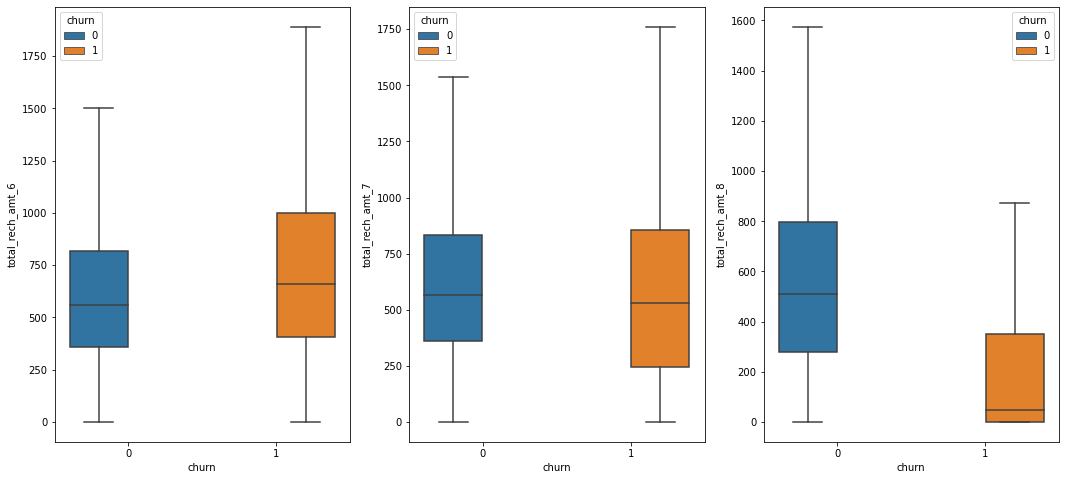

In [30]:
# Plot for total recharge amount
plt.figure(figsize=(18,8))
df = data_high_val_cust


plt.subplot(1,3,1)
sns.boxplot(data=df, y='total_rech_amt_6',x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,2)
sns.boxplot(data=df, y='total_rech_amt_7' ,x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,3)
sns.boxplot(data=df, y='total_rech_amt_8' ,x="churn",hue="churn",showfliers=False)
plt.show()

**Analysis:** 
 - There is a drop in the total recharge amount for churned customers in the 8th Month (Action Phase).

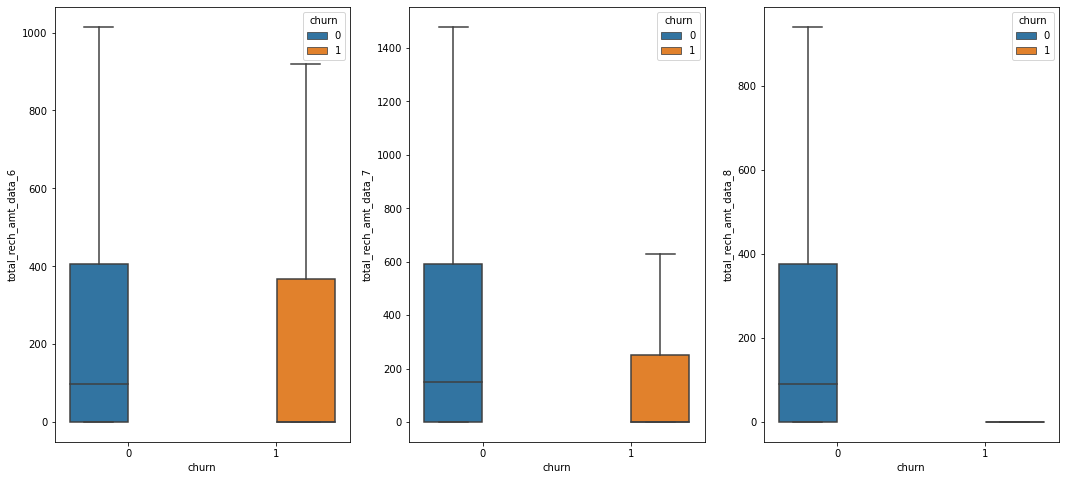

In [31]:
# Plot for total recharge amount for data

plt.figure(figsize=(18,8))
df = data_high_val_cust


plt.subplot(1,3,1)
sns.boxplot(data=df, y='total_rech_amt_data_6',x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,2)
sns.boxplot(data=df, y='total_rech_amt_data_7' ,x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,3)
sns.boxplot(data=df, y='total_rech_amt_data_8' ,x="churn",hue="churn",showfliers=False)
plt.show()


**Analysis:** 
 - There is a huge drop in the total recharge amount for data for churned customers in the 8th Month (Action Phase).

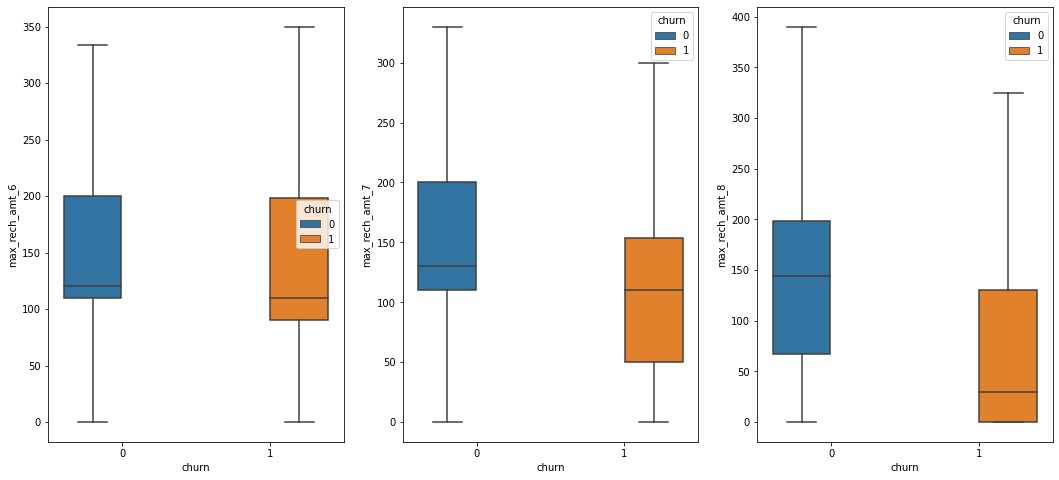

In [32]:
#Plot for maximum recharge amount for data

plt.figure(figsize=(18,8))
df = data_high_val_cust


plt.subplot(1,3,1)
sns.boxplot(data=df, y='max_rech_amt_6',x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,2)
sns.boxplot(data=df, y='max_rech_amt_7' ,x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,3)
sns.boxplot(data=df, y='max_rech_amt_8' ,x="churn",hue="churn",showfliers=False)


plt.show()

**Analysis:** 
 - There is a drop in the maximum recharge amount for data for churned customers in the 8th Month (Action Phase).

In [33]:
# Let's check other recharge related columns
other_recharge_cols = data_high_val_cust.columns[data_high_val_cust.columns.str.contains('rech_num|max_rech_data',regex=True)]
other_recharge_cols

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8'],
      dtype='object')

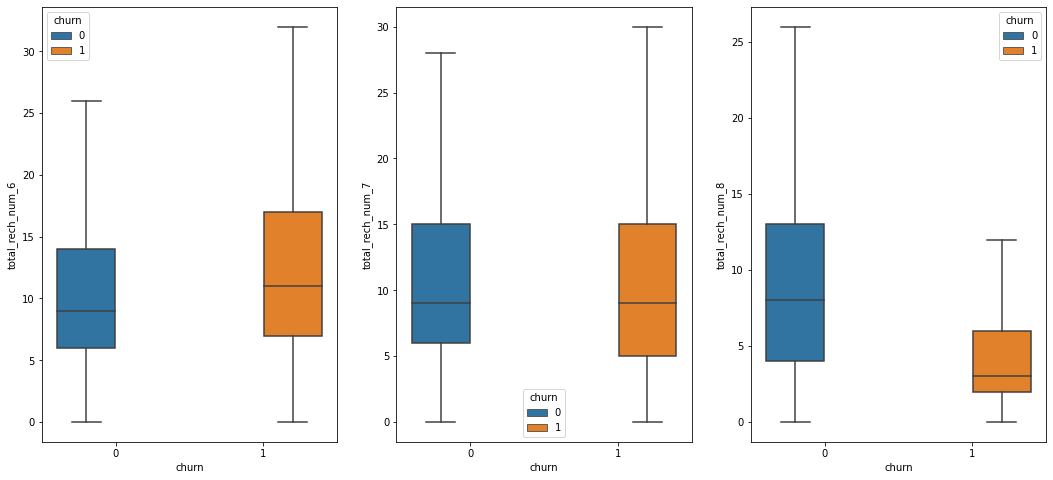

In [34]:
# Plot for total recharge numbers
plt.figure(figsize=(18,8))
df = data_high_val_cust


plt.subplot(1,3,1)
sns.boxplot(data=df, y='total_rech_num_6',x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,2)
sns.boxplot(data=df, y='total_rech_num_7' ,x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,3)
sns.boxplot(data=df, y='total_rech_num_8' ,x="churn",hue="churn",showfliers=False)
plt.show()

**Analysis:** 

 - There is a drop in total recharge number in the 8th month (action phase) for churned customers.

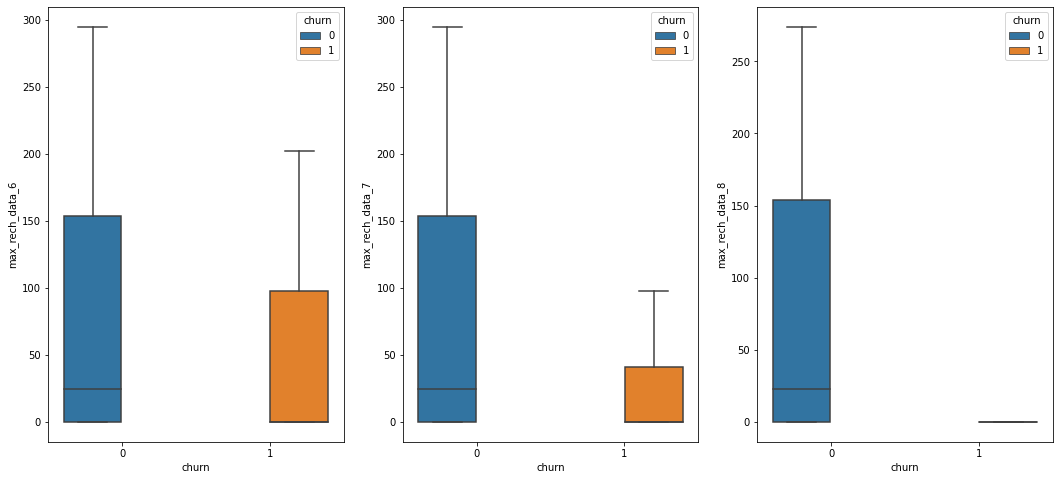

In [35]:
#plot for maximum recharge for data:

plt.figure(figsize=(18,8))
df = data_high_val_cust


plt.subplot(1,3,1)
sns.boxplot(data=df, y='max_rech_data_6',x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,2)
sns.boxplot(data=df, y='max_rech_data_7' ,x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,3)
sns.boxplot(data=df, y='max_rech_data_8' ,x="churn",hue="churn",showfliers=False)


plt.show()


**Analysis:** 
 - There is a huge drop in the maximum recharge for data for churned customers in the 8th Month (Action Phase).

#### b. 2G and 3G usage related attributes

In [36]:
usage_2g_and_3g_cols = data_high_val_cust.columns[data_high_val_cust.columns.str.contains('2g|3g',regex=True)]
usage_2g_and_3g_cols

Index(['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6',
       'vol_3g_mb_7', 'vol_3g_mb_8', 'monthly_2g_6', 'monthly_2g_7',
       'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8',
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'sep_vbc_3g'],
      dtype='object')

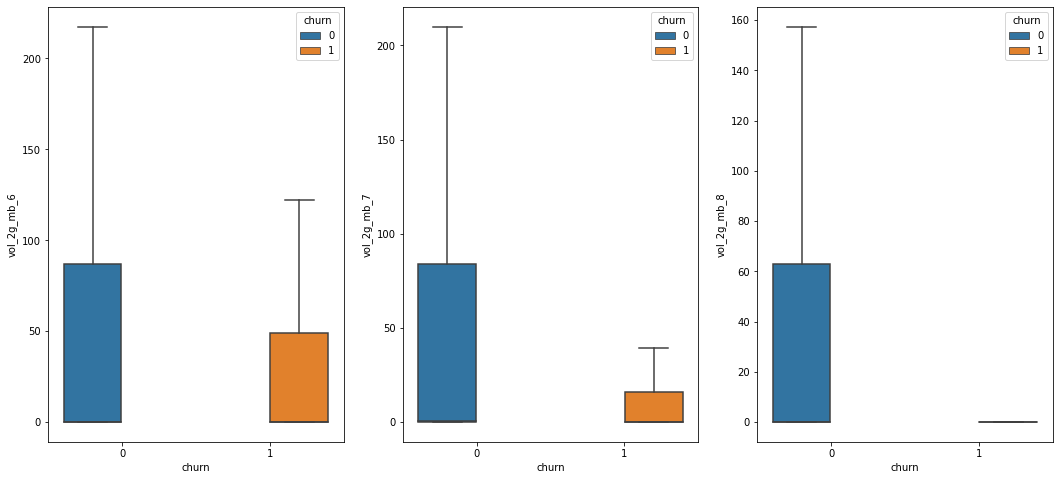

In [37]:
# Plot for volume of 2G usage columns

plt.figure(figsize=(18,8))
df = data_high_val_cust

plt.subplot(1,3,1)
sns.boxplot(data=df, y='vol_2g_mb_6',x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,2)
sns.boxplot(data=df, y='vol_2g_mb_7' ,x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,3)
sns.boxplot(data=df, y='vol_2g_mb_8' ,x="churn",hue="churn",showfliers=False)


plt.show()

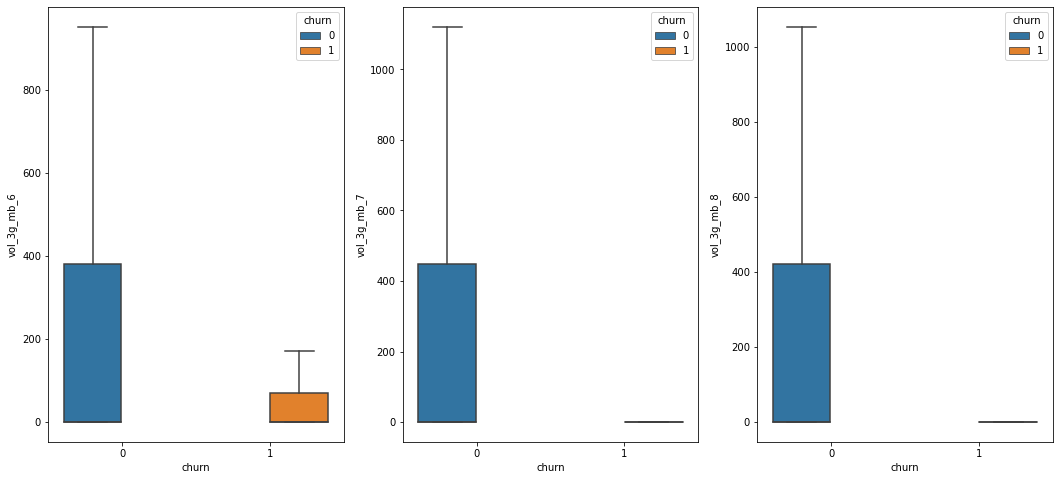

In [38]:
# Plot for volume of 3G usage columns

plt.figure(figsize=(18,8))
df = data_high_val_cust

plt.subplot(1,3,1)
sns.boxplot(data=df, y='vol_3g_mb_6',x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,2)
sns.boxplot(data=df, y='vol_3g_mb_7' ,x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,3)
sns.boxplot(data=df, y='vol_3g_mb_8' ,x="churn",hue="churn",showfliers=False)


plt.show()


**Analysis:** 
 - There is a drop in 2G and 3G usage for churned customers in 7th and 8th month
 - 2G/3G usage is higher for non-churned customers indicating that churned customers might be from areas where 2G/3G service is not properly available

In [39]:
# let's check monthly 2G/3G service schemes
monthly_subcription_2g_3g = data_high_val_cust.columns[data_high_val_cust.columns.str.contains('monthly_2g|monthly_3g',regex=True)]
monthly_subcription_2g_3g

Index(['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_6',
       'monthly_3g_7', 'monthly_3g_8'],
      dtype='object')

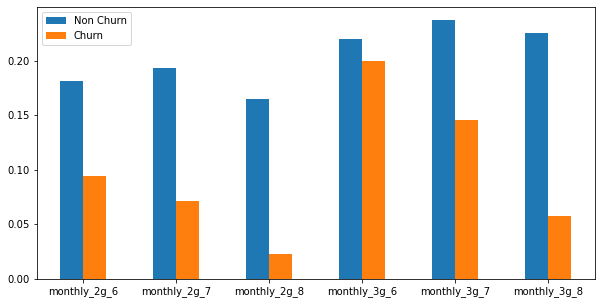

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churn,0.181818,0.193141,0.164925,0.220082,0.237230,0.225289
Churn,0.093957,0.071606,0.023179,0.199503,0.145281,0.057533


In [40]:
#Plot for monthly subscription

def plot_mean_bar_chart(df,columns_list):
    df_0 = df[df.churn==0].filter(columns_list)
    df_1 = df[df.churn==1].filter(columns_list)

    mean_df_0 = pd.DataFrame([df_0.mean()],index={'Non Churn'})
    mean_df_1 = pd.DataFrame([df_1.mean()],index={'Churn'})

    frames = [mean_df_0, mean_df_1]
    mean_bar = pd.concat(frames)

    mean_bar.T.plot.bar(figsize=(10,5),rot=0)
    plt.show()
    
    return mean_bar


plot_mean_bar_chart(data_high_val_cust, monthly_subcription_2g_3g)

**Analysis:** 
    
 - Again we can see a drop in monthly subscription for 2G and 3G for churned customers in 8th Month.

In [41]:
# Renaming month named vbc columns to 6,7,8,9 format
data_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'
                         ,'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

# drop 9th month column
data_high_val_cust.drop('vbc_3g_9',axis=1,inplace=True)

In [42]:
vbc_column = data_high_val_cust.columns[data_high_val_cust.columns.str.contains('vbc_3g',regex=True)]
vbc_column.tolist()

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

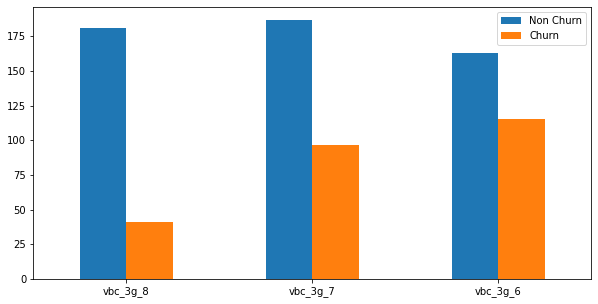

,vbc_3g_8,vbc_3g_7,vbc_3g_6
Non Churn,180.833712,186.621046,162.744884
Churn,41.066126,96.439752,115.239627


In [43]:
plot_mean_bar_chart(data_high_val_cust, vbc_column)

**Analysis:** 
 - Volume based cost for 3G is much lower for Churned customers as compared to Non-Churned Customers and also there is a drop in vbc in 8th month

In [44]:
# Checking Service schemes with validity smaller than a month for 2G/3G
SC_2g_or_3g_col = data_high_val_cust.columns[data_high_val_cust.columns.str.contains('sachet_2g|sachet_3g',regex=True)]


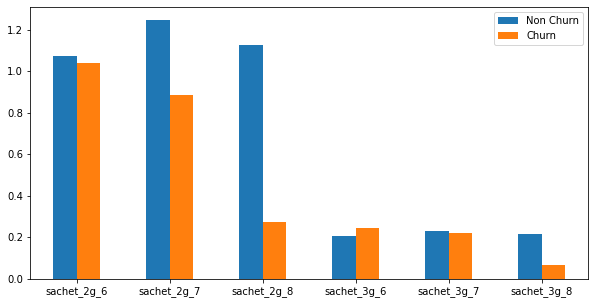

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churn,1.071941,1.246004,1.126406,0.206866,0.228456,0.214621
Churn,1.039321,0.885762,0.271937,0.246275,0.222268,0.065397


In [45]:
plot_mean_bar_chart(data_high_val_cust, SC_2g_or_3g_col)

**Analysis:** 

 - There is a drop in sachet services in 8th month for churned customers

#### c. Average Revenue Per User

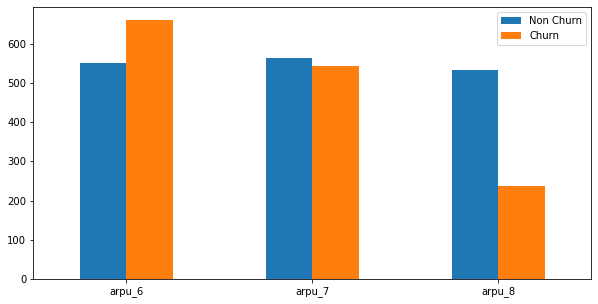

,arpu_6,arpu_7,arpu_8
Non Churn,550.044995,563.336020,533.141898
Churn,660.849219,543.197112,237.940077


In [46]:
# Checking columns for average revenue per user
arpu_cols = data_high_val_cust.columns[data_high_val_cust.columns.str.contains('arpu_')]

# Plotting arpu
plot_mean_bar_chart(data_high_val_cust, arpu_cols)

#### d. Offnet Usage

In [47]:
offnet_usage_service_col = data_high_val_cust.columns[data_high_val_cust.columns.str.contains('offnet.*mou',regex=True)]

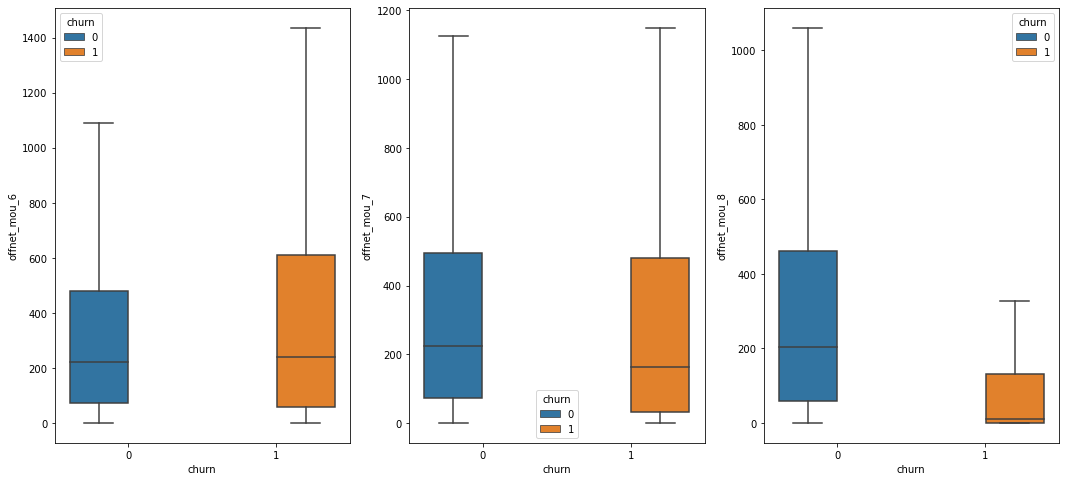

In [48]:
# Offnet mou values for churned and non churned customers

plt.figure(figsize=(18,8))
df = data_high_val_cust

plt.subplot(1,3,1)
sns.boxplot(data=df, y='offnet_mou_6',x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,2)
sns.boxplot(data=df, y='offnet_mou_7' ,x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,3)
sns.boxplot(data=df, y='offnet_mou_8' ,x="churn",hue="churn",showfliers=False)


plt.show()

**Analysis:**
    
 - There is drop for offnet mou services in the 8th month

#### e. ONNET : All kind of calls within the same operator network

In [49]:
#minutes of usage related columns
onnet_usage_service =  data_high_val_cust.columns[data_high_val_cust.columns.str.contains('^onnet.*mou',regex=True)]

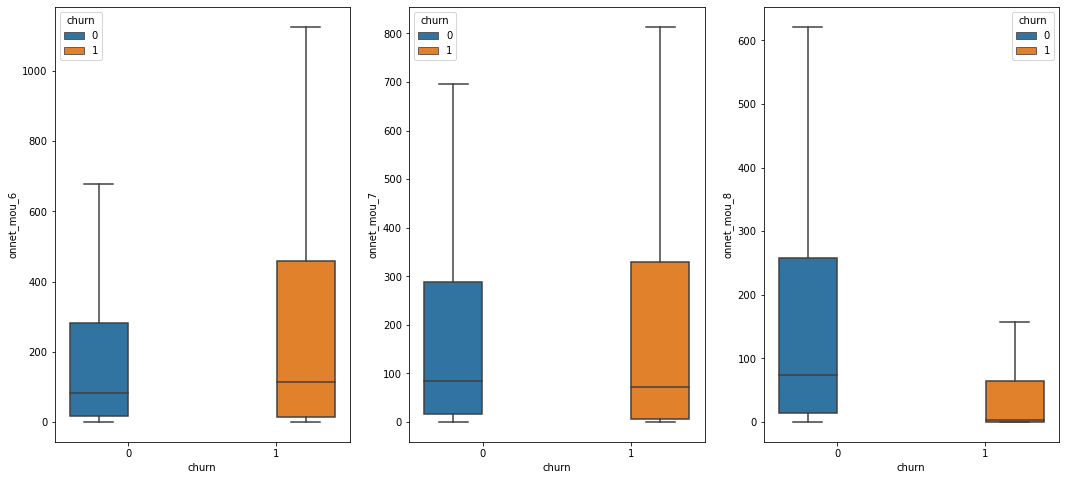

In [50]:
# Onnet mou values for churned and non churned customers

plt.figure(figsize=(18,8))
df = data_high_val_cust

plt.subplot(1,3,1)
sns.boxplot(data=df, y='onnet_mou_6',x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,2)
sns.boxplot(data=df, y='onnet_mou_7' ,x="churn",hue="churn",showfliers=False)
    
plt.subplot(1,3,3)
sns.boxplot(data=df, y='onnet_mou_8' ,x="churn",hue="churn",showfliers=False)


plt.show()

**Analysis:**
    
 - There is drop for onnet mou services in the 8th month

#### f. aon  - Age on network 

In [51]:
tenure_data = data_high_val_cust.copy()

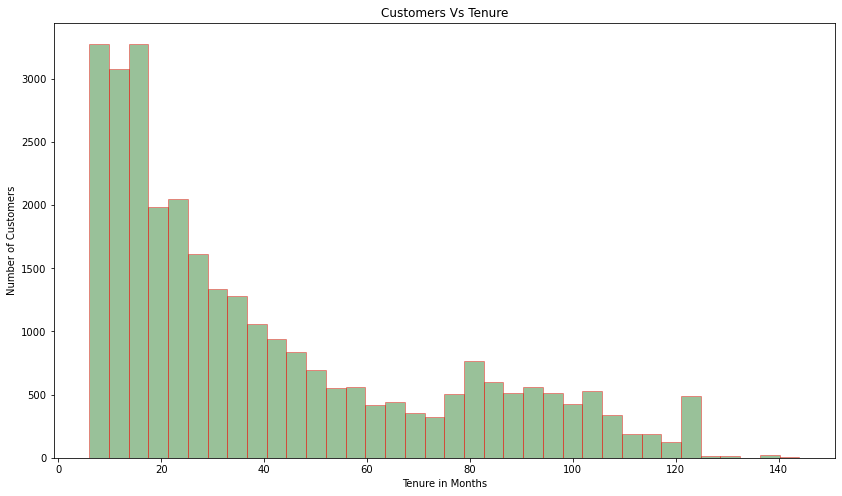

In [52]:
plt.figure(figsize=(14,8))
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()
ax = sns.distplot(tenure_data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [53]:
tenure_range = [0, 6, 12, 24, 60, 61]
tenure_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tenure_range, labels=tenure_label)
tenure_data['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): [0-6 Months < 6-12 Months < 1-2 Yrs < 2-5 Yrs < 5 Yrs and above]

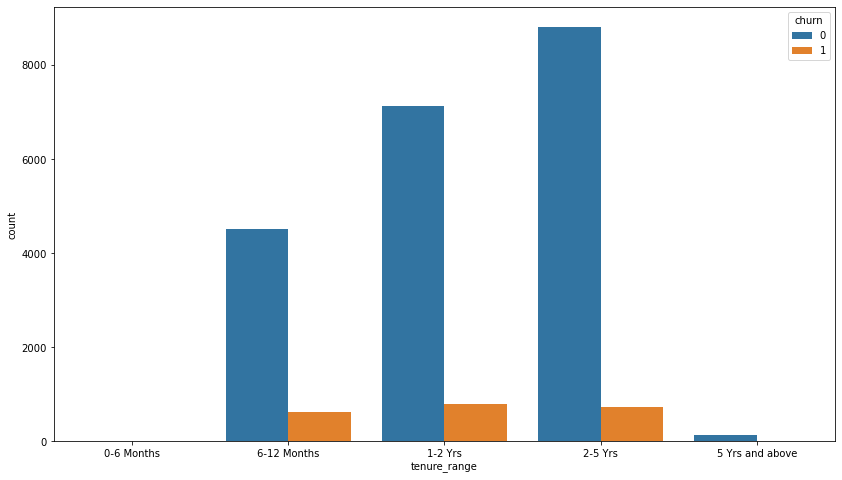

In [54]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data)
plt.show()

**Analysis:**
    
 - As seen from above plot, most of the customers are in range in 2 to 5 years. There are very few customers who are associated with the operator over 5+ years

### Outlier treatment 

In [55]:
data_high_val_cust.describe(percentiles=[.25,.5,.75,.90,.95,.99,1])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_rech_amt_good_phase,churn
count,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.00000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000
mean,559.003366,561.707816,509.275231,261.263434,268.308992,234.428196,374.279117,378.665022,335.474317,16.154555,12.673362,12.537528,26.639943,20.199074,19.931271,84.69

**Analysis:**
    
 -  As seen from above, most of the features have outliers.Hence we will cap the outliers for all the columns to 99 percentile. Capping means any value above the 99 cutoff value will be imputed with the same value

In [56]:
# Outlier Treatement of Columns capping at 99% percentile
for col in data_high_val_cust.columns:
    UL = data_high_val_cust[col].quantile(0.99)
    data_high_val_cust[col] = data_high_val_cust[col].apply(lambda x: UL if(x > UL) else x)

In [57]:
data_high_val_cust.describe(percentiles=[.25,.5,.75,.90,.95,.99,1])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_rech_amt_good_phase,churn
count,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.0,29883.0,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.000000,29883.00000,29883.000000,29883.000000,29883.000000
mean,549.114089,551.629763,498.811663,252.646838,259.106226,225.190444,366.531364,370.057764,325.440724,13.630798,9.672096,9.801099,22.799426,16.725976,16.036683,76.474036,76.8553

In [58]:
data_high_val_cust.shape

(29883, 138)

## Data Modelling


In [59]:
telecom_df = data_high_val_cust.copy()

#### Splitting Data into Training and Test Sets

In [60]:
#Split the dataset into X and y [y is the churn column]
X = telecom_df.drop(['churn'], axis=1)
y = telecom_df['churn']

#### Scale the Data

In [61]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)


In [62]:
#Splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

#### Check  for class imabalance

In [63]:
print("Before OverSampling, counts of label '1' in Train Data Set: {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0' in Train Data Set: {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1' in Train Data Set: 1693
Before OverSampling, counts of label '0' in Train Data Set: 19225 



In [64]:
print("Before OverSampling, counts of label '1' in Test Data Set: {}".format(sum(y_test==1)))
print("Before OverSampling, counts of label '0' in Test Data Set: {} \n".format(sum(y_test==0)))

Before OverSampling, counts of label '1' in Test Data Set: 723
Before OverSampling, counts of label '0' in Test Data Set: 8242 



**Analysis:**
    
 - There is high class imbalance in test and train dataset as seen above.  we should handle this class imbalance using SMOTE

In [65]:
# Use oversampling to do class balancing
sm = SMOTE(random_state=42)

X_bal,y_bal = sm.fit_sample(X_train, y_train)

In [66]:
#Check the data shape after balancing
print("After OverSampling, counts of label '1' in Train Data Set: {}".format(sum(y_bal==1)))
print("After OverSampling, counts of label '0' in Train Data Set: {} \n".format(sum(y_bal==0)))

After OverSampling, counts of label '1' in Train Data Set: 19225
After OverSampling, counts of label '0' in Train Data Set: 19225 



In [67]:
# Calculating the Imbalance on the data after performing the oversampling
imbalance_on_train_data = (y_bal != 0).sum()/(y_bal == 0).sum()
print("After completing the OverSampling imbalance in the Train Data : ",imbalance_on_train_data)

After completing the OverSampling imbalance in the Train Data :  1.0


**Analysis:**
    
 - After Sampling using SMOTE, Imbalance is improved.

### Model 1: Logistic Regression using RFE

In [68]:
lr = LogisticRegression(random_state=1)

# running RFE with 20 variables as output
rfe = RFE(lr, 20)   
rfe = rfe.fit(X_bal, y_bal)

In [69]:
X_rfe = pd.DataFrame(data=X_bal).iloc[:, rfe.support_]
y_rfe = y_bal

In [70]:
telecom_df1 = telecom_df.drop(['churn'], axis=1)

In [71]:
#Check the RFE shortlisted features
rfe_features = list(telecom_df1.columns[rfe.support_])
rfe_features

['onnet_mou_7',
 'offnet_mou_7',
 'loc_og_t2t_mou_7',
 'loc_og_t2m_mou_7',
 'loc_og_mou_7',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'std_og_mou_8',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_8',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'spl_ic_mou_8',
 'last_day_rch_amt_8',
 'total_rech_data_8',
 'max_rech_data_8']

In [72]:
classifier = LogisticRegression(random_state=1)
classifier.fit(X_rfe, y_rfe)

LogisticRegression(random_state=1)

In [73]:
#Predict the test data
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]
y_pred = classifier.predict(X_test_rfe)

In [74]:
#Check the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6760 1482]
 [ 129  594]]


In [75]:
#Check the classification score on this logistic regression model
print('Accuracy of logistic regression classifier on test set: {:.2f}%'.format(round(classifier.score(X_test_rfe, y_test),2)*100))

Accuracy of logistic regression classifier on test set: 82.00%


In [76]:
#print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      8242
           1       0.29      0.82      0.42       723

    accuracy                           0.82      8965
   macro avg       0.63      0.82      0.66      8965
weighted avg       0.93      0.82      0.86      8965



In [77]:
total = sum(sum(confusion_matrix))
accuracy=(confusion_matrix[0,0]+confusion_matrix[1,1])/total

print("Metrics of Logistic Regression with RFE:")
print('Accuracy {0}%: '.format(round(accuracy,2)*100))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print('Sensitivity : {0}%'.format(round(sensitivity,2)*100))

specificity = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
print('Specificity : {0}%'.format(round(specificity,2)*100))

#Check Positives and Negatives
print('True positive = ', confusion_matrix[0][0])
print('False positive = ', confusion_matrix[0][1])
print('False negative = ', confusion_matrix[1][0])
print('True negative = ', confusion_matrix[1][1])

Metrics of Logistic Regression with RFE:
Accuracy 82.0%: 
Sensitivity : 82.0%
Specificity : 82.0%
True positive =  6760
False positive =  1482
False negative =  129
True negative =  594


**Analysis:**
    
 - Top 20 important features identified by Logistic regression using RFE are
 ['onnet_mou_7','offnet_mou_7','loc_og_t2t_mou_7','loc_og_t2m_mou_7',
 'loc_og_mou_7',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'std_og_mou_8',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_8',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'spl_ic_mou_8',
 'last_day_rch_amt_8',
 'total_rech_data_8',
 'max_rech_data_8']

 - Overall accuracy is 82%
 
 - High false positives indicate that model has a drawback and it predicts around 1482 non-churned customers as churned.

## Model 2: Logistic Regression using PCA


In [78]:
# Applying PCA on train data
pca = PCA(random_state=1)

pca.fit(X_bal)

PCA(random_state=1)

In [79]:
#Fit on train dataset
df_train_pca = pca.fit_transform(X_bal)
df_train_pca.shape

#Fit on test dataset
df_test_pca = pca.transform(X_test)
df_test_pca.shape

(8965, 137)

In [80]:
# Now run the model using the selected PCA variables
lr_pca = LogisticRegression()
lr_pca.fit(df_train_pca, y_bal)

# Predicted probabilities
y_pred = lr_pca.predict(df_test_pca)

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [81]:
# Printing confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix1 = confusion_matrix(y_test,y_pred)
print(confusion_matrix1)

[[6938 1304]
 [ 135  588]]


In [82]:
print("Accuracy of Logistic Regression using PCA: {0}%".format(round(accuracy_score(y_test,y_pred),2)*100))

Accuracy of Logistic Regression using PCA: 84.0%


In [83]:
#Check the PCA component values
pca.components_

array([[ 1.56645291e-01,  1.80159763e-01,  1.52888316e-01, ...,
        -7.73433312e-02, -4.26123549e-02, -8.11869983e-03],
       [ 7.54948912e-04,  4.57833639e-02,  1.12248179e-01, ...,
         9.21357974e-02,  8.63153308e-02,  1.02496873e-01],
       [ 9.09838352e-02,  1.49820682e-01,  1.35648577e-01, ...,
         1.33534634e-01,  1.15617031e-01,  1.91771177e-01],
       ...,
       [-1.21678200e-03,  1.30286412e-03,  1.84677603e-03, ...,
        -1.42933408e-03,  1.11403391e-04,  4.68226960e-03],
       [ 0.00000000e+00, -7.11306219e-17, -1.04266718e-16, ...,
         1.62217931e-16, -2.42607629e-16,  8.04720639e-17],
       [ 0.00000000e+00,  1.94402280e-16,  1.27656683e-16, ...,
         7.28326238e-17, -1.27087135e-16,  4.38101358e-17]])

In [84]:
pca.components_[2].shape

(137,)

In [85]:
#Column shortlisted by PCA
colnames = list(telecom_df1.columns)
pca_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':colnames})
pca_df.head(20)

,PC1,PC2,PC3,Feature
0,0.156645,0.000755,0.090984,arpu_6
1,0.180160,0.045783,0.149821,arpu_7
2,0.152888,0.112248,0.135649,arpu_8
3,0.136139,-0.112347,0.055626,onnet_mou_6
4,0.142791,-0.085939,0.084343,onnet_mou_7
5,0.116615,-0.020514,0.075724,onnet_mou_8
6,0.166680,-0.060581,0.007804,offnet_mou_6
7,0.175386,-0.031448,0.045813,offnet_mou_7
8,0.144402,0.035396,0.047071,offnet_mou_8
9,0.020392,-0.008762,0.083955,roam_ic_mou_6


In [86]:
pca_df.Feature.head(20)

0               arpu_6
1               arpu_7
2               arpu_8
3          onnet_mou_6
4          onnet_mou_7
5          onnet_mou_8
6         offnet_mou_6
7         offnet_mou_7
8         offnet_mou_8
9        roam_ic_mou_6
10       roam_ic_mou_7
11       roam_ic_mou_8
12       roam_og_mou_6
13       roam_og_mou_7
14       roam_og_mou_8
15    loc_og_t2t_mou_6
16    loc_og_t2t_mou_7
17    loc_og_t2t_mou_8
18    loc_og_t2m_mou_6
19    loc_og_t2m_mou_7
Name: Feature, dtype: object

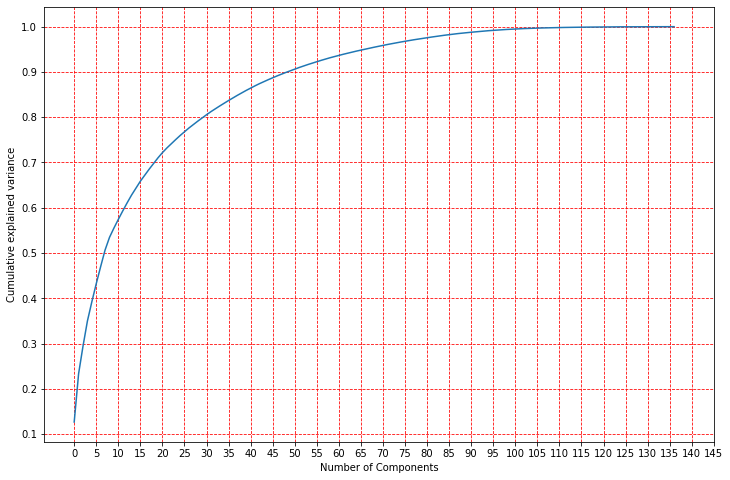

In [87]:
#Plot the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.grid(color='r', linestyle='--')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, 150, 5))
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative explained variance')
plt.show()

**Analysis:**
    
 - As seen from the above plot, 35 variables are able to explain 80% of data variance while 55 variables are able to explain 90% of data variance.

In [88]:
#Since 90% data variance is expalined by 55 variables we will use that value for PCA shortlisting.
pca_55 = PCA(n_components=55)

In [89]:
#Fit PCA on train dataset which is balance using SMOTE earlier
df_train_pca_55 = pca_55.fit_transform(X_bal)
print(df_train_pca_55.shape)

(38450, 55)


In [90]:
#Fit PCA on test dataset 
df_test_pca_55 = pca_55.transform(X_test)

print(df_test_pca_55.shape)

(8965, 55)


### Handling Multi-Collinearity using PCA
Before proceeding lets check if there is any collinearity between the variables

In [91]:
#creating correlation matrix for the principal components
corr_mat = np.corrcoef(df_train_pca_55.transpose())

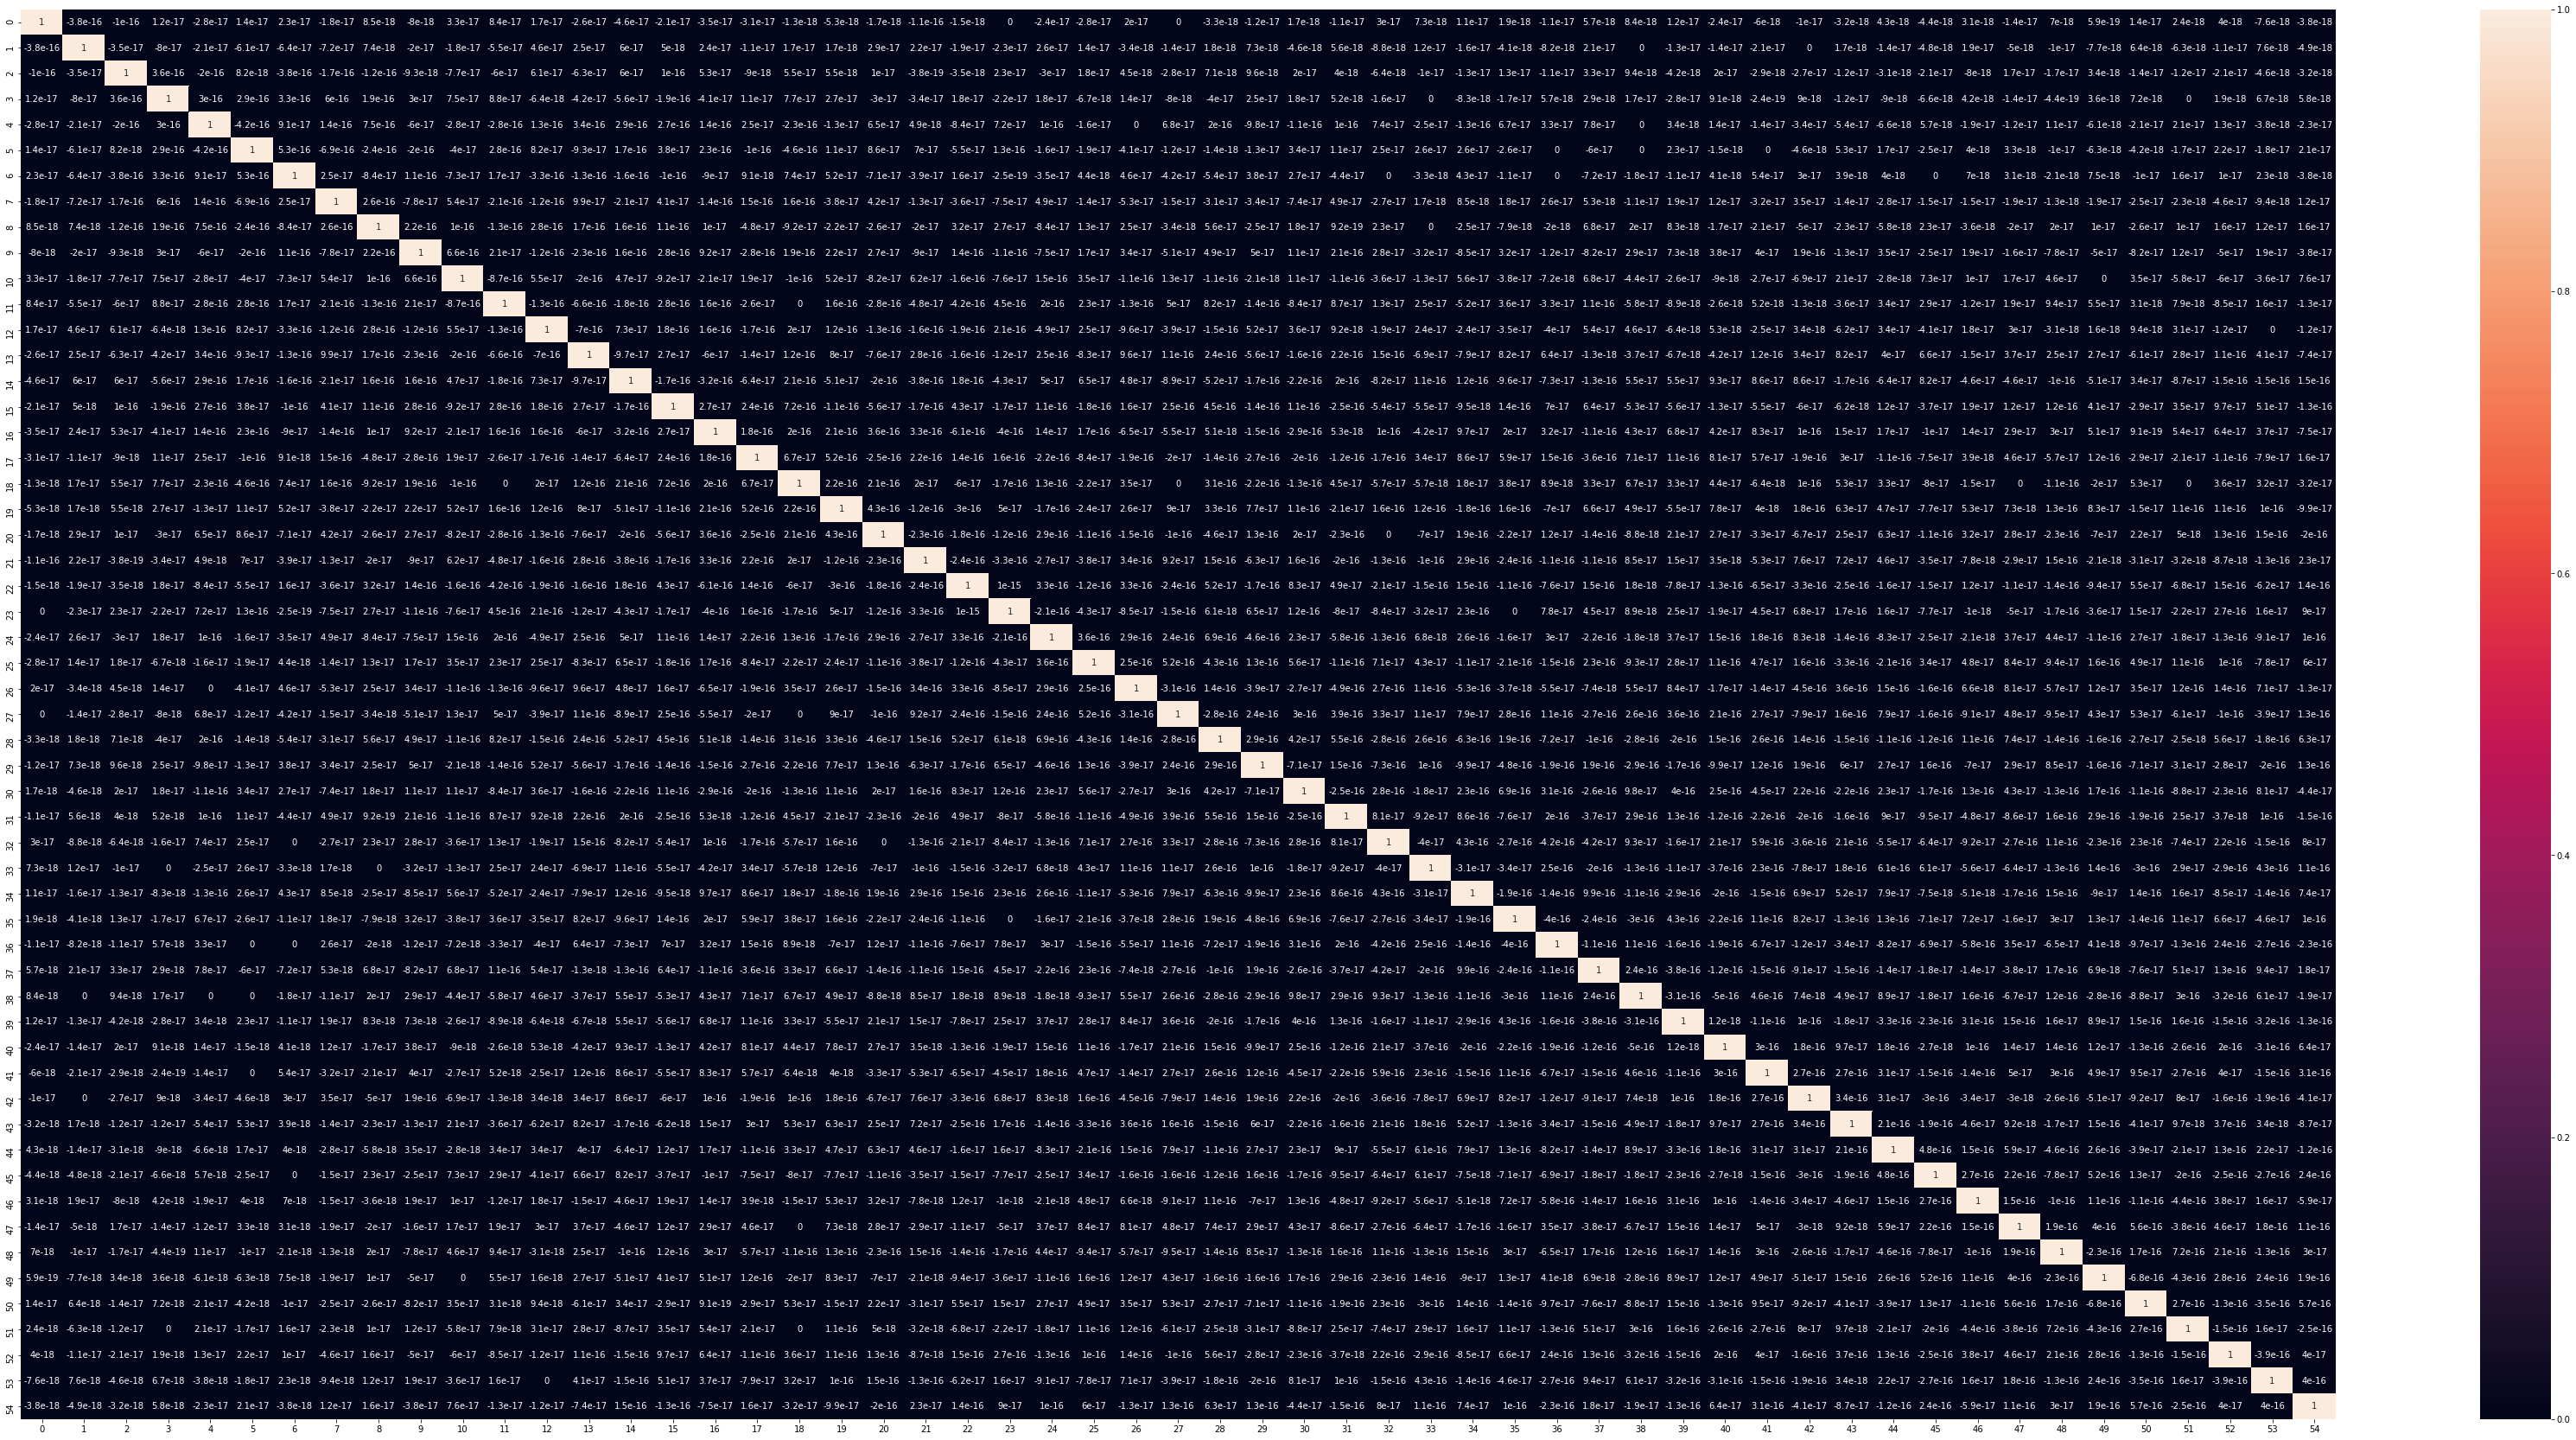

In [92]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (60,30))
sns.heatmap(corr_mat,annot = True)

In [93]:
# Check the correlation between variables
corrmat_nodiag = corr_mat - np.diagflat(corr_mat.diagonal())
print("max corr:",round(corrmat_nodiag.max(),2), ", min corr: ", round(corrmat_nodiag.min(),2),)

max corr: 0.0 , min corr:  -0.0


**Analysis:**
    
 - There is no collinearity between the variables shortlisted by PCA.

In [94]:
lr_pca_55 = LogisticRegression()
lr_pca_55.fit(df_train_pca_55, y_bal)

# Predicted probabilities
y_pred_55 = lr_pca_55.predict(df_test_pca_55)

# Converting y_pred to a dataframe
y_pred_df = pd.DataFrame(y_pred_55)

In [95]:
#print the confusion matrix
cm = confusion_matrix(y_test,y_pred_55)
print(confusion_matrix(y_test,y_pred_55))

[[6875 1367]
 [ 136  587]]


In [96]:
print("Accuracy of Logistic Regression  with PCA (55 variables for 90% data variance): {0}%".format(round(accuracy_score(y_test,y_pred_55),2)*100))

Accuracy of Logistic Regression  with PCA (55 variables for 90% data variance): 83.0%


In [97]:
cm = confusion_matrix(y_test,y_pred_55)

In [98]:
#Check other metrics
total = sum(sum(cm))

accuracy=(cm[0,0]+cm[1,1])/total
print('Accuracy {0}%: '.format(round(accuracy,2)*100))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : {0}%'.format(round(sensitivity,2)*100))

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : {0}%'.format(round(specificity,2)*100))

#Check Positives and Negatives
print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])

Accuracy 83.0%: 
Sensitivity : 83.0%
Specificity : 81.0%
True positive =  6875
False positive =  1367
False negative =  136
True negative =  587


**Analysis:**:

 - 55 variables are used to model PCA whcih can explain 90% of data variance.
 - Logistic Regression with PCA gives 83% accuracy
 - There is no collinearity between the variables shortlisted by PCA.
 - Features shortlisted by PCA are:
arpu_6,
arpu_7,
arpu_8,
onnet_mou_6,
onnet_mou_7,
onnet_mou_8,
offnet_mou_6,
offnet_mou_7,
offnet_mou_8,
roam_ic_mou_6,
roam_ic_mou_7,
roam_ic_mou_8,
roam_og_mou_6,
roam_og_mou_7,
roam_og_mou_8,
loc_og_t2t_mou_6,
loc_og_t2t_mou_7,
loc_og_t2t_mou_8,
loc_og_t2m_mou_6,
loc_og_t2m_mou_7

 - High false positives indicate that model has a drawback and it predicts around 1378 non-churned customers as churned.

## Model 3: Random Forest Classifier

In [99]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [100]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [101]:
# Making predictions
predictions = rfc.predict(X_test)

In [102]:
def plot_confusion_matrix(cm):
    classes=[0,1]
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
consolidate_summary = pd.DataFrame()    
def add_to_global_summary(df) :
    global consolidate_summary 
    consolidate_summary = consolidate_summary.append(df,ignore_index=True)

In [103]:
def print_model_metrics(y_test,y_pred,model_name):
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    plot_confusion_matrix(cp)
    plt.show()
    
    accuracy = round(accuracy_score(y_test,y_pred),2)
    recall = round(recall_score(y_test,y_pred),2)
    precision = round(precision_score(y_test,y_pred),2)
    auc = round(roc_auc_score(y_test,y_pred),2)
    f1 = round(f1_score(y_test,y_pred),2)
    
    data = [[model_name,accuracy,recall,precision,auc,f1]] 
    df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Precision','Recall','AUC','F1'])
    add_to_global_summary(df)
    return df 

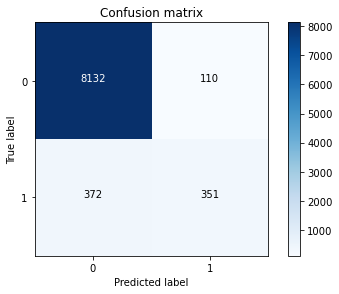

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Default),0.95,0.49,0.76,0.74,0.59


In [104]:
print_model_metrics(y_test,predictions,"RandomForest (Default)")

### Hyperparameter Tuning

In [105]:
def tune_hyperparameter(parameters,x_train,y_train,n_folds = 5,max_depth=0):
    
    if(max_depth==0):
        rf = RandomForestClassifier()
    else :
        rf = RandomForestClassifier(max_depth=max_depth)
        
    rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
    rf.fit(x_train, y_train)
    scores = rf.cv_results_

    for key in parameters.keys():
        hyperparameters = key
        break

    # plotting accuracies for parameters
    plt.figure(figsize=(16,5))
    plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
    plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

#### Tuning max_depth
- Lets find the optimum values for max_depth and understand how the value of max_depth impacts the overall accuracy.


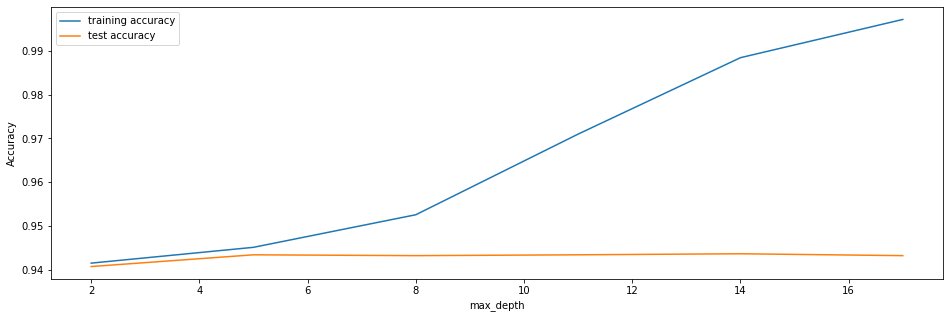

In [106]:
#tune max depth

parameters = {'max_depth': range(2, 20, 3)}
tune_hyperparameter(parameters,X_train,y_train)

**Analysis:** 

 - From the above plot , we see that with max_depth of 2 we can get ~94% accuracy and  with max_depth=5 ~accuracy is >94%

 - As we increase the value of max_depth, both train and test scores increase till a point, but after that test score become stagnant.

#### Tuning n_estimators
- Lets find the optimum values for n_estimators and understand how the value of n_estimators impacts the overall accuracy. 

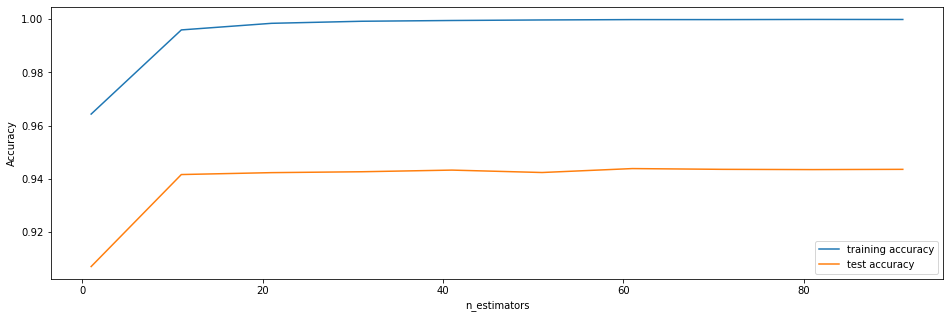

In [107]:
parameters = {'n_estimators': range(1, 100, 10)}
tune_hyperparameter(parameters,X_train,y_train)

**Analysis:** 
 - From above plot , it is seen that at n_estimators to 12 we get >94% accuracy which seems highest for test set after that score almost remain the same . We will use **12** for grid view search.

#### Tuning max_features
- Let check the max_feature considered for splitting at a node.

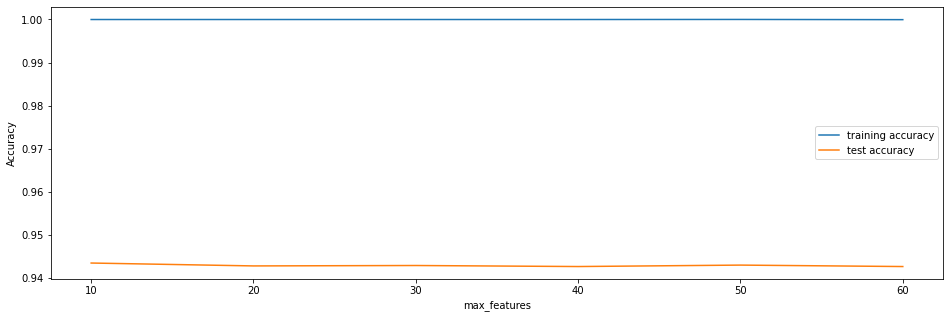

In [108]:
parameters = {'max_features': [10,20,30,40,50,60]}
tune_hyperparameter(parameters,X_train,y_train,4)

**Analysis:** 
Apparently, accuracy of training seems to be stable and test scores seems to increase till **30** and then decrease.

#### Tuning min_samples_leaf
- Let check the min_samples_leaf and min_samples_split

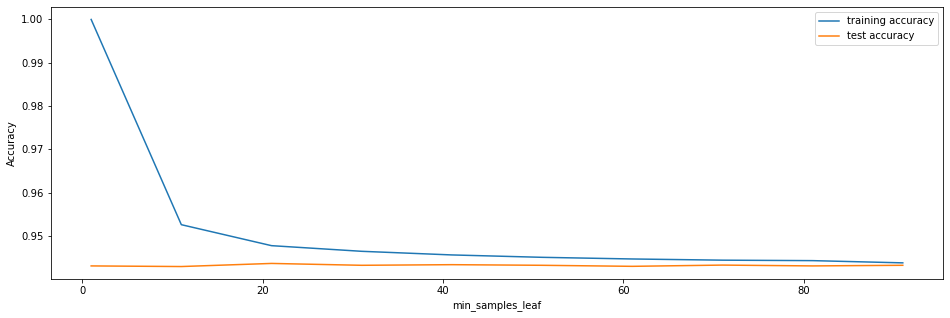

In [109]:
parameters = {'min_samples_leaf': range(1, 100, 10)}
tune_hyperparameter(parameters,X_train,y_train)

**Analysis:** 

 - **10 to 20** seems to be a good range and that will be used in grid search.

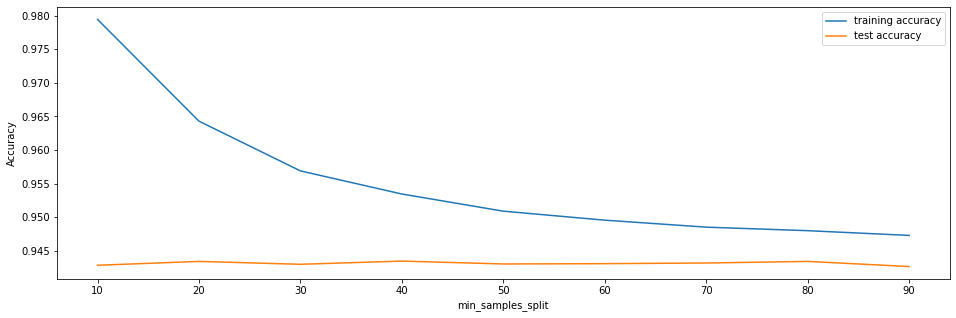

In [110]:
parameters = {'min_samples_split': range(10, 100, 10)}
tune_hyperparameter(parameters,X_train,y_train)

**Analysis:** 

 - Range **20 to 30** is optimal with good accuracy.

### Grid Search to Find Optimal Hyperparameters

In [111]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,6],
    'n_estimators': [12],
    'max_features': [30],
    'min_samples_leaf': [10,20],
    'min_samples_split': [20,30]
}
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,return_train_score=True)

In [112]:
# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 6], 'max_features': [30],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [20, 30], 'n_estimators': [12]},
             return_train_score=True, verbose=1)

In [113]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of '+str(round(rf_grid_search.best_score_,2))+' using '+str(rf_grid_search.best_params_))

We can get accuracy of 0.94 using {'max_depth': 6, 'max_features': 30, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 12}


In [114]:
print("Max accuracy with Random Forest classifier - "+str(round(rf_grid_search.best_score_,2)))

Max accuracy with Random Forest classifier - 0.94


 ### Building and Evaluating the Final Model for Random Forest

In [115]:
rfc = RandomForestClassifier(max_depth=6,
                             max_features=30,
                             min_samples_leaf=20,
                             min_samples_split=20,
                             n_estimators=12,
                             n_jobs = -1)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=6, max_features=30, min_samples_leaf=20,
                       min_samples_split=20, n_estimators=12, n_jobs=-1)

In [116]:
# Making predictions
predictions = rfc.predict(X_test)

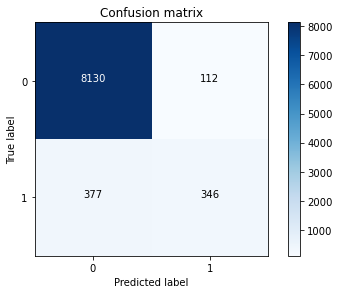

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Hyper),0.95,0.48,0.76,0.73,0.59


In [117]:
# Printing confusion matrix
print_model_metrics(y_test,predictions,'RandomForest (Hyper)')

In [118]:
# Printing confusion matrix
cm = confusion_matrix(y_test,predictions)


In [119]:
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : {0}%'.format(round(sensitivity,2)*100))

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : {0}%'.format(round(specificity,2)*100))

#Check Positives and Negatives
print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])

Sensitivity : 99.0%
Specificity : 48.0%
True positive =  8130
False positive =  112
False negative =  377
True negative =  346


In [120]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = telecom_df1.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [121]:
feature_importances.head(20)

,importance
total_ic_mou_8,0.230214
loc_ic_mou_8,0.120523
total_og_mou_8,0.108243
loc_ic_t2t_mou_8,0.104064
total_rech_amt_8,0.078630
max_rech_amt_8,0.042666
roam_og_mou_8,0.031656
total_rech_data_8,0.023136
max_rech_data_8,0.022320
arpu_8,0.021568


**Analysis:**:

 - We got accuracy of around 94% using random forest classifier
 - False positive is reduced to 127
 - Features shortlisted by random forest classifier are:
total_ic_mou_8,
loc_ic_mou_8,
total_og_mou_8,
loc_ic_t2t_mou_8,
total_rech_amt_8,
max_rech_amt_8,
roam_og_mou_8,
total_rech_data_8,
max_rech_data_8,
arpu_8,
last_day_rch_amt_8,
total_rech_amt_data_8,
av_rech_amt_data_8,
roam_ic_mou_8,
vol_3g_mb_8,
std_og_mou_7,
loc_ic_t2m_mou_8,
total_rech_amt_data_7,
roam_og_mou_7,
total_rech_num_7

## Model 4 - XGBoost

Lets check the accuracy of model with ensemble technique called as XGBoost. The hyperparameters are the same, some important ones being subsample, learning_rate, max_depth etc.


In [122]:
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(X_train, y_train)

[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
# evaluate predictions
y_pred = model.predict(X_test)

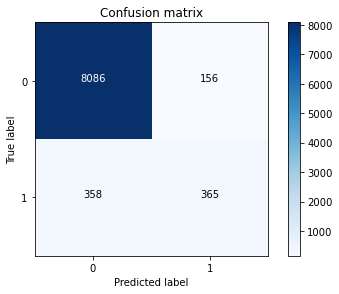

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Default),0.94,0.5,0.7,0.74,0.59


In [124]:
print_model_metrics(y_test, y_pred ,'XGBoost (Default)')

**Analysis:**

 - Area under the curve is 74%. Now lets tune the hyperparameters and see how the model improves.

In [125]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.1,0.2,0.3], 
             'subsample': [0.3,0.4,0.5]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', # accuracy
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)  

In [126]:
# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[15:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [127]:
cv_results_xboost = pd.DataFrame(model_cv.cv_results_)
cv_results_xboost['param_learning_rate'] = cv_results_xboost['param_learning_rate'].astype('float')

In [128]:
# print the optimal accuracy score and hyperparameters
print('We can get accuracy of **'+str(round(model_cv.best_score_,2))+'** using '+str(model_cv.best_params_))

We can get accuracy of **0.94** using {'learning_rate': 0.1, 'subsample': 0.5}


In [129]:
def plot_for_xboost(param_grid,cv_results):
    plt.figure(figsize=(18,5))
    for n, subsample in enumerate(param_grid['subsample']):
        # subplot 1/n
        plt.subplot(1,len(param_grid['subsample']), n+1)
        df = cv_results[cv_results['param_subsample']==subsample]

        plt.plot(df["param_learning_rate"], df["mean_test_score"])
        plt.plot(df["param_learning_rate"], df["mean_train_score"])
        plt.xlabel('learning_rate')
        plt.ylabel('AUC')
        plt.title("subsample={0}".format(subsample))
        plt.ylim([0.60, 1])
        plt.legend(['test score', 'train score'], loc='right left')
        plt.xscale('log')

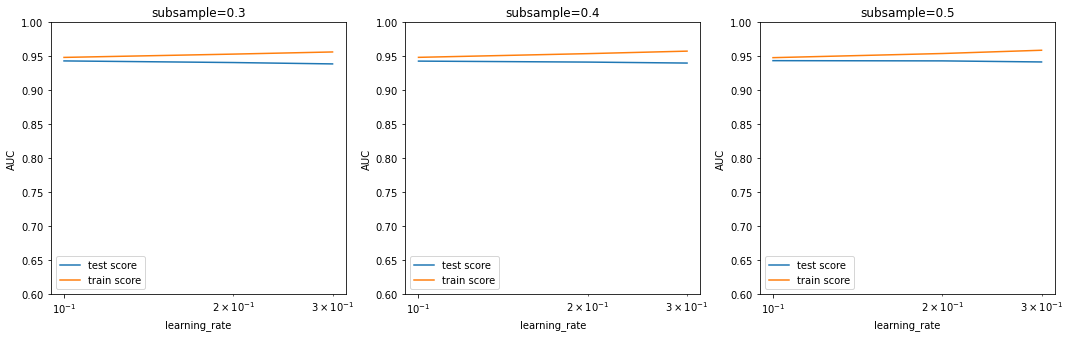

In [130]:
param_grid1 = {'learning_rate': [0.1,0.2,0.3], 'subsample': [0.3,0.4,0.5]}  
plot_for_xboost(param_grid1,cv_results_xboost)


**Analysis:** 

 - The results shows that a subsample size of **0.5** and learning_rate of about **0.3** seems optimal. 
Also, XGBoost has resulted in the highest ROC AUC obtained (across various hyperparameters). 


#### Lets build a final model with the chosen hyperparameters.

In [131]:
params = {'learning_rate': 0.3,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.5,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params,max_depth=2, n_estimators=200)
model.fit(X_train, y_train)

[15:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1,
              params={'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.5},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [132]:
y_pred = model.predict(X_test)

In [133]:
y_pred_prob = model.predict_proba(X_test)

In [134]:
import sklearn
auc = sklearn.metrics.roc_auc_score(y_test, y_pred_prob[:, 1])
print("Area Under Curve of Tuned Model is: {0}%".format(round(auc,2)*100))

Area Under Curve of Tuned Model is: 92.0%


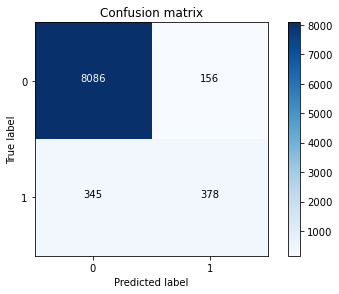

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Hyper Tuned),0.94,0.52,0.71,0.75,0.6


In [135]:
print_model_metrics(y_test, y_pred,'XGBoost (Hyper Tuned)')

In [136]:
# Shortlist the feature according to importance
important_features = dict(zip(telecom_df1.columns, model.feature_importances_))
important_features

{'arpu_6': 0.006018517,
 'arpu_7': 0.008311847,
 'arpu_8': 0.0040511787,
 'onnet_mou_6': 0.0044350713,
 'onnet_mou_7': 0.0058003613,
 'onnet_mou_8': 0.0041498668,
 'offnet_mou_6': 0.0049235327,
 'offnet_mou_7': 0.0019779669,
 'offnet_mou_8': 0.0018384714,
 'roam_ic_mou_6': 0.0034968113,
 'roam_ic_mou_7': 0.0035619235,
 'roam_ic_mou_8': 0.0051706955,
 'roam_og_mou_6': 0.0039036649,
 'roam_og_mou_7': 0.017986866,
 'roam_og_mou_8': 0.019052308,
 'loc_og_t2t_mou_6': 0.0026111153,
 'loc_og_t2t_mou_7': 0.0055935113,
 'loc_og_t2t_mou_8': 0.004093932,
 'loc_og_t2m_mou_6': 0.0039586895,
 'loc_og_t2m_mou_7': 0.0050157686,
 'loc_og_t2m_mou_8': 0.016733592,
 'loc_og_t2f_mou_6': 0.0035365976,
 'loc_og_t2f_mou_7': 0.003616843,
 'loc_og_t2f_mou_8': 0.007274085,
 'loc_og_t2c_mou_6': 0.0035061282,
 'loc_og_t2c_mou_7': 0.0058549386,
 'loc_og_t2c_mou_8': 0.002955522,
 'loc_og_mou_6': 0.0030688173,
 'loc_og_mou_7': 0.003307207,
 'loc_og_mou_8': 0.0049217,
 'std_og_t2t_mou_6': 0.00493281,
 'std_og_t2t_mou_

In [137]:
#Sort the shortlisted features as per importance
import operator
columns_sorted_desc_importance = sorted(important_features.items(), key=operator.itemgetter(1),reverse=True)

In [138]:
columns_sorted_desc_importance[:20]

[('total_ic_mou_8', 0.14432855),
 ('loc_ic_mou_8', 0.06674797),
 ('total_rech_amt_data_8', 0.065838754),
 ('loc_ic_t2m_mou_8', 0.05254505),
 ('av_rech_amt_data_8', 0.050924256),
 ('last_day_rch_amt_8', 0.043247234),
 ('roam_og_mou_8', 0.019052308),
 ('roam_og_mou_7', 0.017986866),
 ('loc_og_t2m_mou_8', 0.016733592),
 ('total_rech_amt_8', 0.016435131),
 ('loc_ic_mou_7', 0.014640337),
 ('std_og_mou_8', 0.014306183),
 ('loc_ic_mou_6', 0.011320715),
 ('spl_ic_mou_8', 0.010336865),
 ('vol_2g_mb_8', 0.01020078),
 ('total_rech_num_6', 0.0090060085),
 ('arpu_7', 0.008311847),
 ('std_og_mou_6', 0.0075069424),
 ('total_rech_amt_good_phase', 0.007404803),
 ('loc_og_t2f_mou_8', 0.007274085)]

**Analysis:**:

 - We got accuracy of around 94% using the ensemble technique -XGBoost 
 - Features shortlisted by XGBoost are:
'total_ic_mou_8',
'loc_ic_mou_8',
'total_rech_amt_data_8',
'loc_ic_t2m_mou_8',
'av_rech_amt_data_8',
'last_day_rch_amt_8',
'roam_og_mou_8',
'roam_og_mou_7',
'loc_og_t2m_mou_8',
'total_rech_amt_8',
'loc_ic_mou_7',
'std_og_mou_8',
'loc_ic_mou_6',
'spl_ic_mou_8',
'vol_2g_mb_8',
'total_rech_num_6',
'arpu_7',
'std_og_mou_6',
'total_rech_amt_good_phase',
'loc_og_t2f_mou_8'

## Summary


1. We tested out 4 different models for building the churn prediction model.

2. The dataset has high rate of class imbalance. So we used data balancing technique like oversampling to balance the dataset and then build the models.

3. We build Logistic Regression with RFE which gave us the accuracy of 82% and high number of false positives.

4. We also build Logistic Regression model with PCA by considering 55 variables that explained 90% of data variance, which gave us the Accuracy of 83% and high number of false positives. We need to keep this value of false positive to minimum to correctly identify the churn customers.

5. Random Forest Classifier gave us the accuracy of 94% and false positives to just 127 which was lowest among all the models.

6. XGBoost also gave us the accuracy of 94% (default overfit model) and 94% with tuned hyperparameters

7. As per our analysis , Random Forest Classifier and XGBoost produce best accuracy and models can be selected to predict churn data for future dataset or production.

8. Based on the features identified we have shortlisted the features which are most common in the models tested above. These features are : total_ic_mou_8, loc_ic_mou_8 , total_rech_amt_data_8 , av_rech_amt_data_8 , last_day_rch_amt_8 , roam_og_mou_8 ,roam_ic_mou_8, loc_ic_t2t_mou_8 , loc_ic_t2m_mou_8 , arpu_7 , arpu_8 ,vol_2g_mb_8,vol_3g_mb_8.

## Recommendations

Following are the recommendations suggested based on the observations from the models tested:

1. Most of the features identified by the models are based on incoming, outgoing and roaming Hence we recommend offering discounted rates for incoming and outgoing calls  on both local and roaming.Higher the incoming roaming amount, higher is the churn rate. Focus on customers whose incoming roaming amount has increased, because they are likely to churn.

2. if the customer tends to recharge with less amount in the action phase, then offer additional data and talktime for these customers to retain them.

4. For the action phase give additional talktime, data and release exclusive offers to retain the customers.

5. Monitor the day of last recharge . if the customer who usually recharges within the first week of the month misses the deadline and doesnt recharge for another week, its a red flag Hence get in touch with those customer .

6. If the average revenue per user for the 7th and 8th month is less than compared to the 6th month, its red flag for churn and the necessary action should be taken.